In [6]:
import os
from pathlib import Path
import dask.dataframe as dd

# === 1) Localiza la carpeta 'notebooks/data/processed' ===
cwd = Path.cwd()  # carpeta actual del notebook
candidatas = [
    cwd / "data" ,
    cwd / "notebooks" / "data",
    cwd.parent / "notebooks" / "data",          # por si estás dentro de notebooks/
    Path("E:/1_IXORIGUE/1_Proyectos/ixo-analitica-soporte/notebooks/data"),  # absoluta (ajusta si hace falta)
]

existe = None
for p in candidatas:
    if p.exists():
        existe = p
        break

print("CWD:", cwd)
print("Ruta elegida:", existe)
if not existe:
    raise FileNotFoundError("No encuentro la carpeta 'notebooks/data/processed' en las rutas candidatas anteriores.")

# Lista rápida de .parquet disponibles
files = sorted(existe.glob("*.parquet"))
print(f"Encontrados {len(files)} .parquet")
for f in files[:10]:
    print(" -", f.name)
if not files:
    raise FileNotFoundError(f"No hay .parquet dentro de {existe}")

# === 2a) Cargar TODOS los parquet de la carpeta (recomendado si son particiones) ===
# Usa wildcard *.parquet: Dask los concatena en un solo DataFrame distribuido
df = dd.read_parquet(str(existe / "*.parquet"), engine="pyarrow")
print("DataFrame Dask cargado con múltiples archivos.")
print(df.head())

# === 2b) (OPCIONAL) Cargar un parquet específico por nombre ===
# Cambia 'mi_archivo.parquet' por el tuyo exacto si prefieres un archivo concreto
nombre_archivo = None  # por ej.: "1_filtrado_almacenamiento_posiciones_60dias_20250916_2209.parquet"
if nombre_archivo:
    ruta_archivo = existe / nombre_archivo
    if not ruta_archivo.exists():
        raise FileNotFoundError(f"No existe: {ruta_archivo}")
    df = dd.read_parquet(str(ruta_archivo), engine="pyarrow")
    print("DataFrame Dask cargado con un único archivo.")
    print(df.head())

# === 3) Consejos de uso con Dask (lazy) ===
# df.shape no funciona directamente: usa compute()
nfilas = df.shape[0].compute()
ncols = len(df.columns)
print(f"Forma: ({nfilas:,}, {ncols})")

print(df.dtypes)  # tipos por columna


CWD: e:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\notebooks
Ruta elegida: e:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\notebooks\data
Encontrados 1 .parquet
 - 1_filtrado_almacenamiento_posiciones_60dias_20250916_2209.parquet
DataFrame Dask cargado con múltiples archivos.
                              device_id serial_number  \
0  00009cfb-9a40-4267-990c-fa825ac59556      70011657   
1  0037fb53-62af-4bdc-93d0-625ed1e76137      70011970   
2  0043835a-d0f4-474f-9b9d-06b662431c70      70010186   
3  004e4e55-4874-490f-b8d8-6b6ce220c124      70010090   
4  005330c0-c384-4ac3-b735-0d497179c70e      70010041   

                   dev_eui      model  uplinks_per_day  \
0  d8:57:c9:fe:ff:e7:0f:fe  ixo_track               36   
1  18:7e:89:fe:ff:d0:b7:46  ixo_track               36   
2  18:6e:54:fe:ff:6e:95:9e  ixo_track               36   
3  f9:df:96:fe:ff:d0:b7:46  ixo_track               36   
4  88:18:94:fe:ff:d0:b7:46  ixo_track               36   

                  timestamp  

In [7]:
# Lista simple de nombres de columnas
print(df.columns.tolist())

# Vista más completa (nombres + tipo de dato)
print(df.dtypes)

# Si son muchas columnas y quieres solo las primeras N
print(df.columns[:10])


['device_id', 'serial_number', 'dev_eui', 'model', 'uplinks_per_day', 'timestamp', 'HasLocation', 'IsValid', 'IsLowAccuracy', 'InvalidReason', 'lat', 'lon', 'ranch_name', 'customer_name', 'animal_eartag', 'animal_name', 'animal_zone_id', 'animal_sex', 'animal_birthdate', 'animal_specie', 'hdop_mean', 'hdop_max', 'hdop_min', 'sat_mean', 'sat_max', 'sat_min', 'ttf_mean', 'ttf_max', 'ttf_min', 'epeh_mean', 'epeh_max', 'epeh_min', 'any_valid_fix', 'devEui', 'n_registros']
device_id               string[pyarrow]
serial_number           string[pyarrow]
dev_eui                 string[pyarrow]
model                   string[pyarrow]
uplinks_per_day                   int64
timestamp           datetime64[ns, UTC]
HasLocation                        bool
IsValid                            bool
IsLowAccuracy                      bool
InvalidReason           string[pyarrow]
lat                             float64
lon                             float64
ranch_name              string[pyarrow]
custome

In [18]:
# Lista de ranch_name a filtrar
ranch_names = [
    "Casa Nasi Joana Casimiro Forestal",
    "Fernando Soto",
    "Adolfo Gutiérrez Gómez",
    "Tomás Gómez Cora",
    "Rocío Moreno de Castro Josep Buenaventura Forestal",
    "Miquel Boixadera Ballarà",
    "Armando Bartolomé González",
    "Pedro Manenti",
    "Reyes Manenti",
    "Javier Algueta",
    "José López Arnejo",
    "Alicia Fernández Corrales",
    "Miren Meabe Cerro",
    "Javier Laplaza Ipas",
    "Andrés Sanz",
    "Gerard Cardona  Tremp",
    "Ángeles María Collado",
    "Josep corts - casa nasi",
    "Jordi Pinassa - Rocamora",
    "Raúl Berridi Inguanzo",
    "Javier Pérez Bonilla",
    "Héctor Febles Acosta",
    "Miguel Zoco"
]

# Lista de modelos permitidos
models = ["ixo_track_pro", "cow_pro"]

# Filtrar en Dask DataFrame
df_filtrado = df[
    df["ranch_name"].isin(ranch_names) &
    df["model"].isin(models)
]

# Ver primeras filas
print(df_filtrado.head())

# Nº de filas filtradas
print("Filas filtradas:", df_filtrado.shape[0].compute())


                                 device_id serial_number  \
2906  51aabf21-5bb7-4a4c-8cf5-01b28405068b      70015305   
2908  8b6dcacf-e7e5-44f7-a32d-7f2b408ceee5      70015325   
2911  c88f00df-3f03-40db-94a4-e466154dc237      70014208   
2912  a2e4c42f-bf53-44a3-af20-82e65bc1ed67      70014216   
2915  c1ae4413-7206-42d5-a9a4-d4dc75a75aca      70014662   

                      dev_eui          model  uplinks_per_day  \
2906  8c:1f:64:46:50:00:12:26  ixo_track_pro               36   
2908  8c:1f:64:46:50:00:0b:85  ixo_track_pro               36   
2911  8c:1f:64:46:50:00:0e:55  ixo_track_pro               36   
2912  8c:1f:64:46:50:00:10:a9  ixo_track_pro               36   
2915  8c:1f:64:46:50:00:0d:d5  ixo_track_pro               36   

                            timestamp  HasLocation  IsValid  IsLowAccuracy  \
2906 2025-07-18 21:00:13.296563+00:00        False    False          False   
2908 2025-07-18 21:00:14.816412+00:00        False    False          False   
2911 2025-07-1

In [ ]:
# Lista completa de dev_eui filtrados
dev_euis = df_filtrado["dev_eui"].dropna().unique().compute().tolist()

print("Nº dispositivos:", len(dev_euis))
for eui in dev_euis:
    print(eui)


Nº dispositivos: 248
8c:1f:64:46:50:00:12:26
8c:1f:64:46:50:00:10:a9
8c:1f:64:46:50:00:0d:d5
8c:1f:64:46:50:00:0d:a2
8c:1f:64:46:50:00:10:b1
8c:1f:64:46:50:00:11:fc
8c:1f:64:46:50:00:0b:15
8c:1f:64:46:50:00:0c:81
8c:1f:64:46:50:00:0c:73
8c:1f:64:46:50:00:0e:ab
8c:1f:64:46:50:00:0b:67
8c:1f:64:46:50:00:06:f4
8c:1f:64:46:50:00:03:49
8c:1f:64:46:50:00:05:de
8c:1f:64:46:50:00:0d:2f
8c:1f:64:46:50:00:0e:6e
8c:1f:64:46:50:00:0e:48
8c:1f:64:46:50:00:0e:24
8c:1f:64:46:50:00:0d:69
8c:1f:64:46:50:00:0d:ba
8c:1f:64:46:50:00:10:51
8c:1f:64:46:50:00:0e:f6
8c:1f:64:46:50:00:11:9f
8c:1f:64:46:50:00:0e:74
8c:1f:64:46:50:00:11:8a
8c:1f:64:46:50:00:0e:bb
8c:1f:64:46:50:00:0e:60
8c:1f:64:46:50:00:0a:ab
8c:1f:64:46:50:00:06:5e
8c:1f:64:46:50:00:0d:5b
8c:1f:64:46:50:00:0a:6a
8c:1f:64:46:50:00:10:ec
8c:1f:64:46:50:00:01:65
8c:1f:64:46:50:00:0c:93
8c:1f:64:46:50:00:0b:c4
8c:1f:64:46:50:00:0c:ef
8c:1f:64:46:50:00:10:d8
8c:1f:64:46:50:00:11:3a
8c:1f:64:46:50:00:0e:8d
8c:1f:64:46:50:00:0d:b0
8c:1f:64:46:50:00:0

In [49]:
# ====== TTF medio A/B con conexión a Elasticsearch (TODO EN ESTA CELDA) ======
# Requiere que ya exista la variable `dev_euis` (o `dev_eus`) en el notebook.

from typing import List, Optional, Tuple, Dict, Any
from datetime import datetime
import re
import json
import requests
from requests.auth import HTTPBasicAuth
import urllib3
import pandas as pd
from IPython.display import display

# ------------------------ CONEXIÓN ELASTICSEARCH ------------------------
ES_BASE_URL = "https://10.0.1.9:31900"   # <--- TU ENDPOINT
ES_USER     = "guillermo"                # <--- TU USUARIO
ES_PASS     = "changeMe!"                # <--- TU PASSWORD
ES_VERIFY_SSL = False                    # <--- False si usas cert no verificado

INDEX_DEFAULT = "devices_locations"      # <--- TU ÍNDICE
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def es_post(index: str, body: Dict[str, Any]) -> Dict[str, Any]:
    url = f"{ES_BASE_URL.rstrip('/')}/{index}/_search"
    r = requests.post(url, json=body,
                      auth=HTTPBasicAuth(ES_USER, ES_PASS),
                      headers={"Content-Type":"application/json"},
                      verify=ES_VERIFY_SSL, timeout=120)
    r.raise_for_status()
    return r.json()

# ------------------------ PARÁMETROS DE VENTANAS ------------------------
# Ventanas por defecto (mes-día); el AÑO se auto-detecta según tus datos
A_MMDD = ("07-22", "08-22")   # [22/07, 22/08)
B_MMDD = ("08-27", "09-15")   # [27/08, 15/09)

# Si quieres forzarun año concreto, descomenta:
FORCE_YEAR = 2025
FORCE_YEAR = None  # o un entero (p. ej. 2024)

# ------------------------ UTILIDADES ------------------------
def _iso(dt_like: Any) -> str:
    """Normaliza a ISO-8601 Zulu (UTC)."""
    if isinstance(dt_like, str):
        dt = pd.to_datetime(dt_like, utc=True, errors="coerce")
    elif isinstance(dt_like, datetime):
        dt = pd.Timestamp(dt_like, tz="UTC")
    elif isinstance(dt_like, pd.Timestamp):
        dt = dt_like.tz_convert("UTC") if dt_like.tz is not None else dt_like.tz_localize("UTC")
    else:
        raise ValueError(f"Formato de fecha no soportado: {type(dt_like)}")
    if pd.isna(dt):
        raise ValueError(f"Fecha inválida: {dt_like}")
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

def normalize_euis(euis: List[str]) -> List[str]:
    """Convierte '8c:1f:...' -> '8c1f...' (16 hex en minúsculas, sin separadores)."""
    out, seen = [], set()
    for e in euis:
        if e is None: 
            continue
        s = re.sub(r'[^0-9a-f]', '', str(e).strip().lower())
        if len(s) == 16 and s not in seen:
            out.append(s); seen.add(s)
    return out

def detect_year_with_data(index: str, norm_euis: List[str]) -> Optional[int]:
    """Devuelve el año del último documento para tus EUIs."""
    q = {
        "size": 1,
        "query": {"bool": {"must": [{"terms": {"devEui.keyword": norm_euis}}]}},
        "sort": [{"timestamp": {"order": "desc"}}]
    }
    r = es_post(index, q)
    hits = r.get("hits", {}).get("hits") or []
    if not hits:
        return None
    ts = hits[0]["_source"]["timestamp"]
    year = pd.to_datetime(ts, utc=True, errors="coerce").year
    print(f"Último documento: {ts} → año detectado: {year}")
    return int(year)

def agg_ttf_media(
    start_dt: Any,
    end_dt: Any,
    dev_euis_norm: List[str],
    index: str,
    require_time_to_fix: bool = True,
    require_has_location: bool = True,
) -> Tuple[Optional[float], pd.DataFrame]:
    """TTF medio (global y por devEui) usando agregaciones."""
    start_str, end_str = _iso(start_dt), _iso(end_dt)
    must_filters = [
        {"terms": {"devEui.keyword": dev_euis_norm}},
        {"range": {"timestamp": {"gte": start_str, "lt": end_str}}}
    ]
    if require_time_to_fix:
        must_filters.append({"exists": {"field": "timeToFix"}})
    filt = [{"term": {"hasLocation": True}}] if require_has_location else []

    q = {
        "query": {"bool": {"must": must_filters, **({"filter": filt} if filt else {})}},
        "size": 0,
        "aggs": {
            "global_avg": {"avg": {"field": "timeToFix"}},
            "por_dev": {
                "terms": {"field": "devEui.keyword", "size": max(1000, len(dev_euis_norm)+50)},
                "aggs": {"avg_ttf": {"avg": {"field": "timeToFix"}}}
            }
        }
    }
    r = es_post(index, q)
    g = (r.get("aggregations", {}).get("global_avg", {}) or {}).get("value")
    global_sec = None if g is None else g/1000.0

    buckets = (r.get("aggregations", {}).get("por_dev", {}) or {}).get("buckets", []) or []
    rows = []
    for b in buckets:
        v = b.get("avg_ttf", {}).get("value")
        rows.append({
            "devEui": b.get("key"),
            "ttf_avg_sec": None if v is None else v/1000.0
        })
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values("ttf_avg_sec", na_position="last")
    return global_sec, df

# ------------------------ TOMAR TU LISTA DEL NB ------------------------
if 'dev_euis' in globals():
    raw_euis = globals()['dev_euis']
elif 'dev_eus' in globals():
    raw_euis = globals()['dev_eus']
else:
    raise NameError("No encuentro la variable 'dev_euis' (ni 'dev_eus'). Crea esa lista antes de ejecutar esta celda.")

norm_euis = normalize_euis(raw_euis)
print(f"EUIs: originales={len(raw_euis)}  →  normalizados={len(norm_euis)} (formato ES: 16 hex sin ':')")

if not norm_euis:
    raise ValueError("Tras normalizar, la lista queda vacía. Revisa el formato de los dev_eui.")

# ------------------------ AUTODETECCIÓN DE AÑO ------------------------
year = FORCE_YEAR if FORCE_YEAR else detect_year_with_data(INDEX_DEFAULT, norm_euis)
if not year:
    raise RuntimeError("No se detectaron datos para esos EUIs en el índice. Revisa índice/euis.")
A_START = f"{year}-{A_MMDD[0]}T00:00:00Z"; A_END = f"{year}-{A_MMDD[1]}T00:00:00Z"
B_START = f"{year}-{B_MMDD[0]}T00:00:00Z"; B_END = f"{year}-{B_MMDD[1]}T00:00:00Z"
print(f"Ventana A: {A_START} → {A_END}")
print(f"Ventana B: {B_START} → {B_END}")

# ------------------------ EJECUCIÓN ------------------------
print("\n=== Ventana A ===")
A_global, A_df = agg_ttf_media(A_START, A_END, norm_euis, INDEX_DEFAULT, True, True)
print("TTF medio A (s):", "sin datos" if A_global is None else f"{A_global:.2f}", "  filas:", len(A_df))

print("=== Ventana B ===")
B_global, B_df = agg_ttf_media(B_START, B_END, norm_euis, INDEX_DEFAULT, True, True)
print("TTF medio B (s):", "sin datos" if B_global is None else f"{B_global:.2f}", "  filas:", len(B_df))

# Si no hay datos con filtros, intenta una pasada sin filtros estrictos
if (A_df.empty and B_df.empty):
    print("\n⚠️ Sin datos con filtros (hasLocation/timeToFix). Reintentamos sin filtros extra.")
    A_global, A_df = agg_ttf_media(A_START, A_END, norm_euis, INDEX_DEFAULT, False, False)
    B_global, B_df = agg_ttf_media(B_START, B_END, norm_euis, INDEX_DEFAULT, False, False)
    print("Reintento A (s):", "sin datos" if A_global is None else f"{A_global:.2f}", "  filas:", len(A_df))
    print("Reintento B (s):", "sin datos" if B_global is None else f"{B_global:.2f}", "  filas:", len(B_df))

# ------------------------ DELTAS POR DISPOSITIVO ------------------------
if not (A_df.empty and B_df.empty):
    df_delta = (A_df.rename(columns={"ttf_avg_sec":"ttf_A"})
                .merge(B_df.rename(columns={"ttf_avg_sec":"ttf_B"}), on="devEui", how="outer"))
    df_delta["delta_B_minus_A"] = df_delta["ttf_B"] - df_delta["ttf_A"]
    df_delta = df_delta.sort_values("delta_B_minus_A", ascending=False, na_position="last")
    print("\nTop 20 dispositivos con mayor delta (B–A):")
    display(df_delta.head(20))
    # display(df_delta.tail(20))  # los que más mejoran
else:
    print("No hay datos por dispositivo para calcular deltas. Revisa EUIs/fechas/índice.")


EUIs: originales=248  →  normalizados=248 (formato ES: 16 hex sin ':')


RuntimeError: No se detectaron datos para esos EUIs en el índice. Revisa índice/euis.

In [19]:
# === Requisitos ===
import dask.dataframe as dd
import pandas as pd

# -----------------------------------------------------------
# 1) Partimos de df_filtrado (Dask DataFrame)
#    Debe contener al menos: device_id, serial_number, ranch_name, timestamp, ttf_mean
# -----------------------------------------------------------

# --- Parámetros de configuración ---
LOCAL_TZ = None   # usa None para agrupar por día en UTC
EXPORTAR = False  # pon True si quieres exportar a parquet/csv
OUT_PARQUET = "daily_ttf_mean.parquet"
OUT_CSV = "daily_ttf_mean.csv"

# -----------------------------------------------------------
# 2) Limpieza mínima + asegurar tipos
# -----------------------------------------------------------
cols_necesarias = ["device_id", "serial_number", "ranch_name", "timestamp", "ttf_mean"]
faltantes = [c for c in cols_necesarias if c not in df_filtrado.columns]
if faltantes:
    raise ValueError(f"Faltan columnas requeridas en df_filtrado: {faltantes}")

dfw = df_filtrado[cols_necesarias].dropna(subset=["ttf_mean"])

# Asegurar timestamp datetime con tz
dfw["timestamp"] = dd.to_datetime(dfw["timestamp"], utc=True, errors="coerce")

# Si hubiera algún timestamp inválido, los quitamos
dfw = dfw.dropna(subset=["timestamp"])

# -----------------------------------------------------------
# 3) Derivar la fecha natural para la agregación diaria
# -----------------------------------------------------------
if LOCAL_TZ:
    dfw["fecha"] = dfw["timestamp"].dt.tz_convert(LOCAL_TZ).dt.date
else:
    dfw["fecha"] = dfw["timestamp"].dt.date

# -----------------------------------------------------------
# 4) Agregación: promedio diario de ttf_mean por device_id (+ recuento)
# -----------------------------------------------------------
df_daily = (
    dfw.groupby(["ranch_name", "serial_number", "device_id", "fecha"])
       .agg(
           ttf_mean_diario=("ttf_mean", "mean"),
           n_mensajes=("timestamp", "count")
       )
       .reset_index()
)

# df_daily sigue siendo Dask -> muestra rápida
print("Vista rápida (head) sin traer todo a memoria:")
print(df_daily.head())

# Si necesitas el resultado completo en pandas:
df_daily_pd = df_daily.compute().sort_values(["ranch_name", "serial_number", "device_id", "fecha"]).reset_index(drop=True)

print("\nPrimeras filas (pandas):")
print(df_daily_pd.head())

print("\nInfo del resultado (pandas):")
print(df_daily_pd.info())

# -----------------------------------------------------------
# 5) (Opcional) Exportar a parquet/csv
# -----------------------------------------------------------
if EXPORTAR:
    # Parquet (recomendado)
    df_daily.to_parquet(OUT_PARQUET, write_index=False)  # exportación en Dask
    # CSV (necesita traer a memoria)
    df_daily_pd.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
    print(f"\n📁 Exportado: {OUT_PARQUET} y {OUT_CSV}")


Vista rápida (head) sin traer todo a memoria:
                 ranch_name serial_number  \
0  Miquel Boixadera Ballarà      70015325   
1            Javier Algueta      70014216   
2            Javier Algueta      70014187   
3         Miren Meabe Cerro      70015297   
4          Tomás Gómez Cora      70015286   

                              device_id       fecha  ttf_mean_diario  \
0  8b6dcacf-e7e5-44f7-a32d-7f2b408ceee5  2025-07-18        22.865982   
1  a2e4c42f-bf53-44a3-af20-82e65bc1ed67  2025-07-18        40.333333   
2  7b0765a7-226c-42c7-b3bd-3dbb1eb45bfe  2025-07-18        45.401344   
3  0b10d82e-ac8a-466c-88ee-4c7f3460fd15  2025-07-18        32.664557   
4  fd09fde2-5fde-4093-af89-58dc0e9e568c  2025-07-18        45.208506   

   n_mensajes  
0           3  
1           3  
2           3  
3           3  
4          14  

Primeras filas (pandas):
               ranch_name serial_number                             device_id  \
0  Adolfo Gutiérrez Gómez      70012289  7875f0

In [20]:
import dask.dataframe as dd
import pandas as pd

# -----------------------------------------------------------
# Partimos de df_filtrado (Dask DataFrame)
# Debe tener: ranch_name, timestamp, ttf_mean
# -----------------------------------------------------------
# Ejemplo de carga (si lo necesitas):
# df_filtrado = dd.read_parquet("notebooks/data/processed/tu_archivo.parquet")

# === Configuración de zona horaria para "día natural" ===
LOCAL_TZ = None   # None => agrupar por día en UTC; p.ej. "Europe/Madrid" para hora local

# === Validación de columnas ===
req = {"ranch_name", "timestamp", "ttf_mean"}
missing = req - set(df_filtrado.columns)
if missing:
    raise ValueError(f"Faltan columnas en df_filtrado: {sorted(missing)}")

# Asegurar timestamp tz-aware y limpiar nulos de ttf_mean
dfw = df_filtrado[["ranch_name", "timestamp", "ttf_mean"]].dropna(subset=["ttf_mean"])
dfw["timestamp"] = dd.to_datetime(dfw["timestamp"], utc=True, errors="coerce")
dfw = dfw.dropna(subset=["timestamp"])

def preparar_periodo(df, start_str, end_str, dayfirst=True, tz=LOCAL_TZ):
    """
    Filtra df entre [start, end] INCLUSIVO y devuelve:
      - daily_mean: media diaria de ttf_mean por ranch_name
      - period_mean: media del periodo por ranch_name (promedio de las medias diarias)
    """
    # Parseo robusto de fechas
    start = pd.to_datetime(start_str, dayfirst=dayfirst, utc=True)
    end   = pd.to_datetime(end_str,   dayfirst=dayfirst, utc=True)

    # Normalizar orden
    if start > end:
        start, end = end, start

    # Filtro inclusivo: [start, end]
    dff = df[(df["timestamp"] >= start) & (df["timestamp"] <= end)]

    # Derivar fecha natural
    if tz:
        fecha = dff["timestamp"].dt.tz_convert(tz).dt.date
    else:
        fecha = dff["timestamp"].dt.date

    dff = dff.assign(fecha=fecha)

    # 1) Media diaria por ganadería
    daily_mean = (
        dff.groupby(["ranch_name", "fecha"])
           .agg(
               ttf_mean_diario=("ttf_mean", "mean"),
               n_mensajes=("ttf_mean", "count")
           )
           .reset_index()
    )

    # 2) Media del periodo por ganadería (promedio de las medias diarias)
    #    Si prefieres ponderar por nº de mensajes, cambia a:
    #    sum(ttf_mean_diario * n_mensajes) / sum(n_mensajes)
    period_mean = (
        daily_mean.groupby("ranch_name")
                  .agg(
                      ttf_mean_periodo=("ttf_mean_diario", "mean"),
                      dias_con_datos=("fecha", "count"),
                      n_total=("n_mensajes", "sum")
                  )
                  .reset_index()
    )

    return daily_mean, period_mean

# --- Periodo A: 22/07/2025 – 21/08/2025 (dd/mm/yyyy) ---
daily_A, period_A = preparar_periodo(dfw, "22/07/2025", "21/08/2025", dayfirst=True, tz=LOCAL_TZ)

# --- Periodo B: 14/04/2025 – 27/08/2025 (ordeno las fechas cronológicamente) ---
daily_B, period_B = preparar_periodo(dfw, "14/04/2025", "27/08/2025", dayfirst=True, tz=LOCAL_TZ)

# --- Vistas rápidas (no traen todo a memoria) ---
print("Daily A (head):")
print(daily_A.head())
print("\nPeriod A (head):")
print(period_A.head())

print("\nDaily B (head):")
print(daily_B.head())
print("\nPeriod B (head):")
print(period_B.head())

# --- Si necesitas el resultado completo en pandas ---
daily_A_pd  = daily_A.compute().sort_values(["ranch_name", "fecha"])
period_A_pd = period_A.compute().sort_values(["ranch_name"])

daily_B_pd  = daily_B.compute().sort_values(["ranch_name", "fecha"])
period_B_pd = period_B.compute().sort_values(["ranch_name"])

print("\nResumen Periodo A (pandas):")
print(period_A_pd.head())

print("\nResumen Periodo B (pandas):")
print(period_B_pd.head())

# --- (Opcional) Exportar ---
# daily_A.to_parquet("daily_ttf_mean_periodoA.parquet", write_index=False)
period_A_pd.to_csv("period_mean_periodoA.csv", index=False, encoding="utf-8-sig")
# daily_B.to_parquet("daily_ttf_mean_periodoB.parquet", write_index=False)
period_B_pd.to_csv("period_mean_periodoB.csv", index=False, encoding="utf-8-sig")


Daily A (head):
                 ranch_name       fecha  ttf_mean_diario  n_mensajes
0  Miquel Boixadera Ballarà  2025-07-22        24.642076         941
1            Javier Algueta  2025-07-22        46.712944        1348
2             Reyes Manenti  2025-07-22        47.981791         144
3         Miren Meabe Cerro  2025-07-22        46.816754         556
4          Tomás Gómez Cora  2025-07-22        44.206080         301

Period A (head):
                 ranch_name  ttf_mean_periodo  dias_con_datos  n_total
0  Miquel Boixadera Ballarà         24.669062              30    32145
1            Javier Algueta         46.277135              30    48709
2             Reyes Manenti         47.981791              30     1790
3         Miren Meabe Cerro         47.000148              30    17601
4          Tomás Gómez Cora         43.684374              30     6719

Daily B (head):
                 ranch_name       fecha  ttf_mean_diario  n_mensajes
0  Miquel Boixadera Ballarà  2025-07-18 

In [28]:
# --- Calcular periodos ---
daily_A, period_A = preparar_periodo(dfw, "22/07/2025", "21/08/2025", dayfirst=True, tz=LOCAL_TZ)
daily_B, period_B = preparar_periodo(dfw, "14/04/2025", "27/08/2025", dayfirst=True, tz=LOCAL_TZ)

# --- Convertir a pandas ---
period_A_pd = period_A.compute()
period_B_pd = period_B.compute()

# --- Renombrar columnas ---
period_A_pd = period_A_pd.rename(columns={"ttf_mean_periodo": "ttf_mean_periodo_A"})
period_B_pd = period_B_pd.rename(columns={"ttf_mean_periodo": "ttf_mean_periodo_B"})

# --- Unir por ranch_name ---
comparacion = pd.merge(
    period_A_pd[["ranch_name", "ttf_mean_periodo_A"]],
    period_B_pd[["ranch_name", "ttf_mean_periodo_B"]],
    on="ranch_name",
    how="outer"  # para no perder ganaderías que aparezcan solo en un periodo
)

# --- Calcular diferencia ---
comparacion["diferencia_A_B"] = (
    comparacion["ttf_mean_periodo_A"] - comparacion["ttf_mean_periodo_B"]
)

# --- Ordenar por nombre de ganadería ---
comparacion = comparacion.sort_values("ranch_name").reset_index(drop=True)

print(comparacion.head())

# (Opcional) exportar
# comparacion.to_csv("comparacion_periodos.csv", index=False, encoding="utf-8-sig")


                          ranch_name  ttf_mean_periodo_A  ttf_mean_periodo_B  \
0             Adolfo Gutiérrez Gómez           33.546481           33.639375   
1          Alicia Fernández Corrales           41.321724           40.716881   
2                        Andrés Sanz           28.310410           28.970253   
3         Armando Bartolomé González           43.466288           43.149817   
4  Casa Nasi Joana Casimiro Forestal           56.496243           56.332504   

   diferencia_A_B  
0       -0.092895  
1        0.604842  
2       -0.659843  
3        0.316471  
4        0.163738  


In [27]:
import pandas as pd

# --- Periodos ---
periodo_a = ("2025-07-22", "2025-08-21")
periodo_b = ("2025-08-27", "2025-09-14")

# --- Helper: media general por ganadería en un rango ---
def media_por_ranch(ddf, start, end):
    ddf_rango = ddf[(ddf["timestamp"] >= start) & (ddf["timestamp"] <= end)]
    return (
        ddf_rango.groupby("ranch_name")["ttf_mean"]
                 .mean()
                 .reset_index()
                 .compute()
    )

# --- Calcular ambos periodos ---
df_a = media_por_ranch(df_filtrado, *periodo_a).rename(columns={"ttf_mean": "periodo_a"})
df_b = media_por_ranch(df_filtrado, *periodo_b).rename(columns={"ttf_mean": "periodo_b"})

# --- Unir en un solo DF ---
df_periodos = pd.merge(df_a, df_b, on="ranch_name", how="outer")

# Calcular diferencia A - B
df_periodos["diferencia"] = df_periodos["periodo_a"] - df_periodos["periodo_b"]

# --- Ordenar por diferencia para ver más claro ---
df_periodos = df_periodos.sort_values("diferencia", ascending=False).reset_index(drop=True)

print(df_periodos.head(20))


                                           ranch_name  periodo_a  periodo_b  \
0                                Héctor Febles Acosta  32.997765  27.295840   
1   Rocío Moreno de Castro Josep Buenaventura Fore...  47.188631  42.303295   
2                                    Tomás Gómez Cora  43.892194  40.060003   
3                               Gerard Cardona  Tremp  48.544966  45.026145   
4                                   José López Arnejo  37.745865  34.403737   
5                                Javier Pérez Bonilla  35.054440  32.689743   
6                           Alicia Fernández Corrales  41.730796  39.477005   
7                          Armando Bartolomé González  43.645295  42.189353   
8                                       Fernando Soto  35.539251  34.319384   
9                                   Miren Meabe Cerro  47.040063  45.949113   
10                                Javier Laplaza Ipas  44.839638  43.775275   
11                              Ángeles María Collad

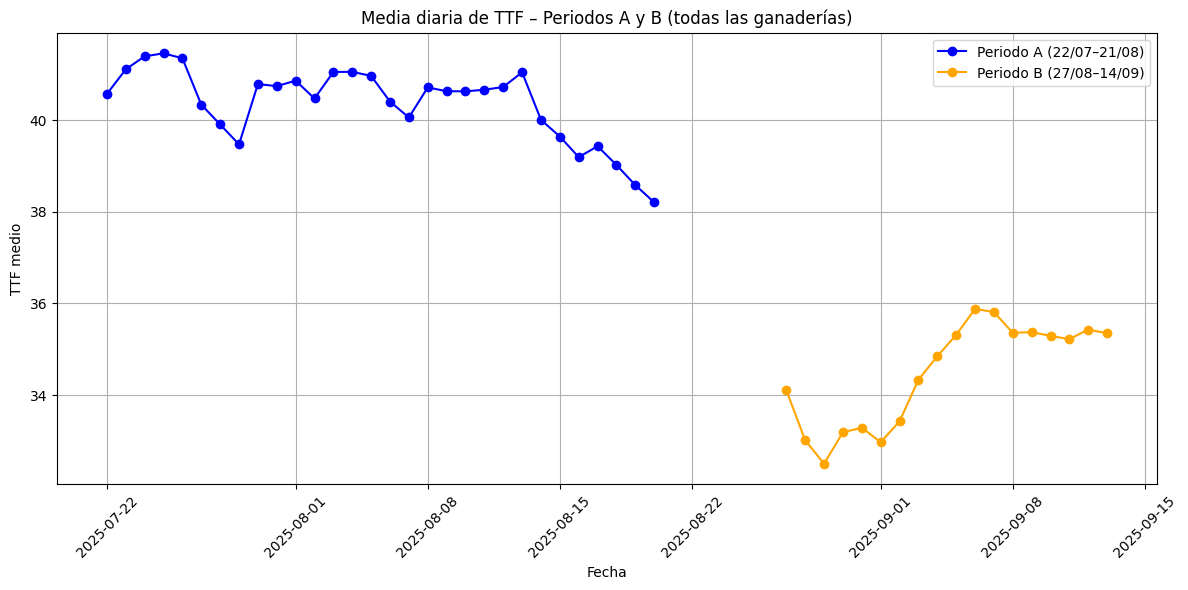

In [26]:
import matplotlib.pyplot as plt

# --- Definición de periodos ---
periodo_a = ("2025-07-22", "2025-08-21")
periodo_b = ("2025-08-27", "2025-09-14")

# --- Asegurar timestamp como datetime ---
df_filtrado["timestamp"] = dd.to_datetime(df_filtrado["timestamp"], utc=True, errors="coerce")
df_filtrado["fecha"] = df_filtrado["timestamp"].dt.date

# --- Periodo A ---
df_a = df_filtrado[
    (df_filtrado["timestamp"] >= periodo_a[0]) &
    (df_filtrado["timestamp"] <= periodo_a[1])
]
df_a_daily = (
    df_a.groupby("fecha")["ttf_mean"]
        .mean()
        .reset_index()
    .compute()
)
df_a_daily["periodo"] = "A"

# --- Periodo B ---
df_b = df_filtrado[
    (df_filtrado["timestamp"] >= periodo_b[0]) &
    (df_filtrado["timestamp"] <= periodo_b[1])
]
df_b_daily = (
    df_b.groupby("fecha")["ttf_mean"]
        .mean()
        .reset_index()
    .compute()
)
df_b_daily["periodo"] = "B"

# --- Concatenar ---
df_total = pd.concat([df_a_daily, df_b_daily], ignore_index=True)

# --- Graficar ---
plt.figure(figsize=(12,6))

# Línea periodo A
plt.plot(
    df_total[df_total["periodo"] == "A"]["fecha"],
    df_total[df_total["periodo"] == "A"]["ttf_mean"],
    color="blue", marker="o", label="Periodo A (22/07–21/08)"
)

# Línea periodo B
plt.plot(
    df_total[df_total["periodo"] == "B"]["fecha"],
    df_total[df_total["periodo"] == "B"]["ttf_mean"],
    color="orange", marker="o", label="Periodo B (27/08–14/09)"
)

plt.title("Media diaria de TTF – Periodos A y B (todas las ganaderías)")
plt.xlabel("Fecha")
plt.ylabel("TTF medio")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


CASO ARMANDO

In [30]:
# Filtrar toda la ganadería Armando Bartolomé González
df_armando = df[df["ranch_name"] == "Armando Bartolomé González"].compute()

# Ahora df_armando es un pandas DataFrame
print(df_armando.shape)
print(df_armando.head())
print(df_armando.info())


(21367, 35)
                                   device_id serial_number  \
334117  aa186cc3-9b3b-418f-b74c-fd9ebcb31b6e      70016001   
334788  059b338f-1cf7-4573-b432-1a963b67a4fd      70015999   
339600  059b338f-1cf7-4573-b432-1a963b67a4fd      70015999   
343539  aa186cc3-9b3b-418f-b74c-fd9ebcb31b6e      70016001   
359448  059b338f-1cf7-4573-b432-1a963b67a4fd      70015999   

                        dev_eui          model  uplinks_per_day  \
334117  8c:1f:64:46:50:00:11:47  ixo_track_pro               36   
334788  8c:1f:64:46:50:00:12:02  ixo_track_pro               36   
339600  8c:1f:64:46:50:00:12:02  ixo_track_pro               36   
343539  8c:1f:64:46:50:00:11:47  ixo_track_pro               36   
359448  8c:1f:64:46:50:00:12:02  ixo_track_pro               36   

                              timestamp  HasLocation  IsValid  IsLowAccuracy  \
334117 2025-07-24 02:22:29.111825+00:00        False    False          False   
334788        2025-07-24 02:37:58+00:00         True

In [31]:
# --- Periodos ---
periodo_a = ("2025-07-22", "2025-08-21")
periodo_b = ("2025-08-27", "2025-09-14")

# Filtrar Armando
df_armando = df[df["ranch_name"] == "Armando Bartolomé González"]

# Asegurar tipo datetime
df_armando["timestamp"] = dd.to_datetime(df_armando["timestamp"], utc=True, errors="coerce")

# --- Periodo A ---
df_a = df_armando[(df_armando["timestamp"] >= periodo_a[0]) & (df_armando["timestamp"] <= periodo_a[1])]
ttf_a = df_a["ttf_mean"].mean().compute()

# --- Periodo B ---
df_b = df_armando[(df_armando["timestamp"] >= periodo_b[0]) & (df_armando["timestamp"] <= periodo_b[1])]
ttf_b = df_b["ttf_mean"].mean().compute()

# --- Resultado en un DataFrame pandas ---
import pandas as pd

df_armando_periodos = pd.DataFrame({
    "ranch_name": ["Armando Bartolomé González"],
    "periodo_a": [ttf_a],
    "periodo_b": [ttf_b],
    "diferencia": [ttf_a - ttf_b]
})

print(df_armando_periodos)


                   ranch_name  periodo_a  periodo_b  diferencia
0  Armando Bartolomé González  43.645295  42.189353    1.455943


📁 CSV exportado en: C:\Users\usuario\Desktop\armando_periodo_b_ttf_mean_pro.csv


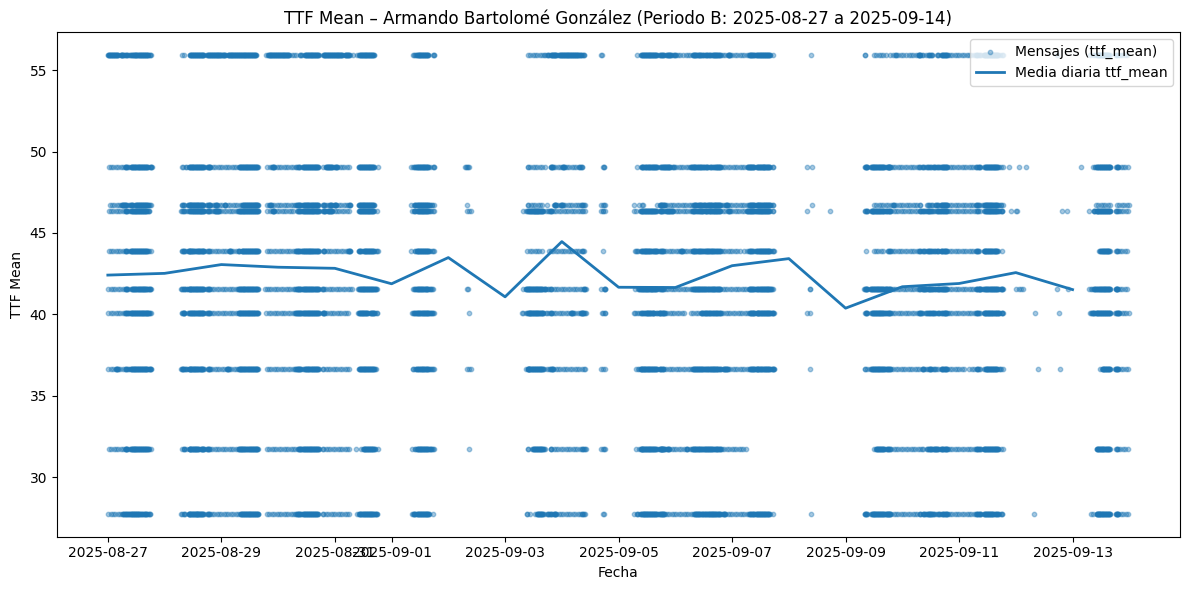

🖼️ Gráfica guardada en: C:\Users\usuario\Desktop\armando_periodo_b_ttf_mean_pro.png


In [35]:
import os
from pathlib import Path
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

# =========================
#  Configuración
# =========================
PERIODO_B = ("2025-08-27", "2025-09-14")
MODELOS_PRO = ["ixo_track_pro", "cow_pro"]
RANCH = "Armando Bartolomé González"

# Rutas de salida en ESCRITORIO Windows (C:\Users\<usuario>\Desktop\...)
desktop = Path.home() / "Desktop"
desktop.mkdir(parents=True, exist_ok=True)

csv_out = desktop / "armando_periodo_b_ttf_mean_pro.csv"
png_out = desktop / "armando_periodo_b_ttf_mean_pro.png"

# =========================
#  Si ya tienes `df` (Dask) en memoria, no hace falta cargar.
#  Si no, descomenta y ajusta la ruta de tu parquet:
# df = dd.read_parquet("notebooks/data/processed/tu_archivo.parquet")
# =========================

# --- Filtrado (Dask -> Pandas) ---
df_armando_b = (
    df[(df["ranch_name"] == RANCH) &
       (df["timestamp"] >= PERIODO_B[0]) &
       (df["timestamp"] <= PERIODO_B[1]) &
       (df["model"].isin(MODELOS_PRO))]
    [["timestamp", "device_id", "serial_number", "model", "ttf_mean"]]
)

# A pandas y orden
df_armando_b_pd = (
    df_armando_b.compute()
    .copy()
    .sort_values("timestamp")
    .reset_index(drop=True)
)

# Exportar a CSV en Escritorio
df_armando_b_pd.to_csv(csv_out, index=False, encoding="utf-8-sig")
print(f"📁 CSV exportado en: {csv_out}")

# =========================
#  Gráfica ttf_mean del periodo
#  - puntos por mensaje
#  - línea de media diaria
# =========================
# Asegurar tipo datetime (por si llega como string)
df_armando_b_pd["timestamp"] = pd.to_datetime(df_armando_b_pd["timestamp"], utc=True, errors="coerce")
df_armando_b_pd = df_armando_b_pd.dropna(subset=["timestamp", "ttf_mean"])

# Media diaria
daily_mean = (
    df_armando_b_pd
    .set_index("timestamp")
    .groupby(pd.Grouper(freq="D"))["ttf_mean"]
    .mean()
    .dropna()
)

plt.figure(figsize=(12, 6))
# Puntos individuales (suaves si hay muchos)
plt.scatter(df_armando_b_pd["timestamp"], df_armando_b_pd["ttf_mean"], s=10, alpha=0.4, label="Mensajes (ttf_mean)")
# Línea media diaria
plt.plot(daily_mean.index, daily_mean.values, linewidth=2, label="Media diaria ttf_mean")

plt.title(f"TTF Mean – {RANCH} (Periodo B: {PERIODO_B[0]} a {PERIODO_B[1]})")
plt.xlabel("Fecha")
plt.ylabel("TTF Mean")
plt.legend()
plt.tight_layout()

# Guardar PNG en Escritorio
plt.savefig(png_out, dpi=150)
plt.show()
print(f"🖼️ Gráfica guardada en: {png_out}")


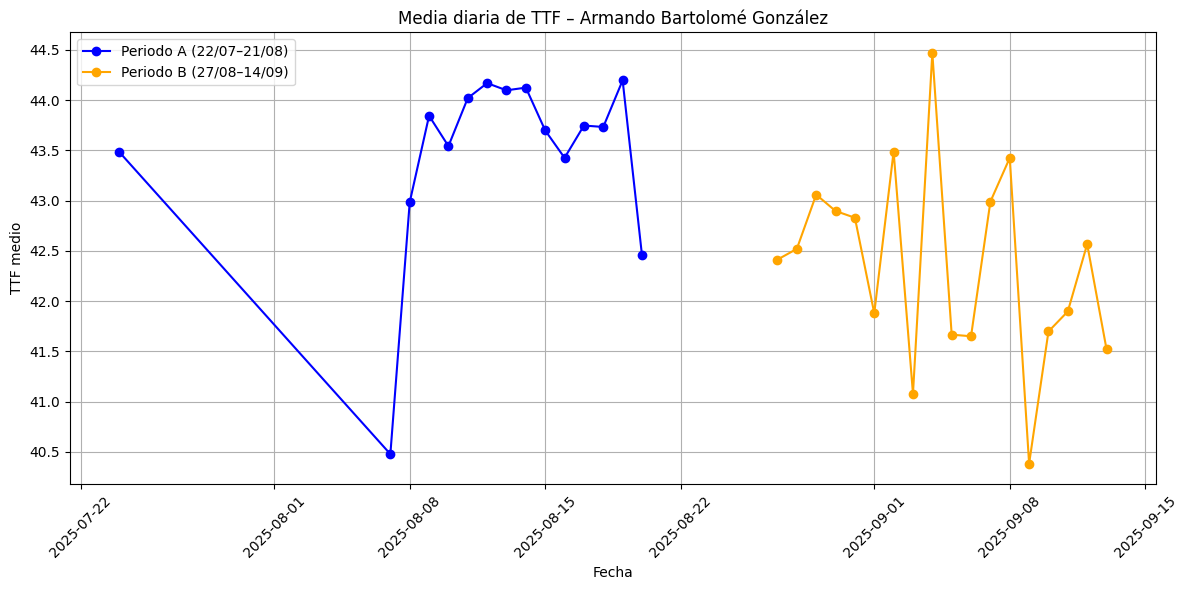

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd

# --- Definición de periodos ---
periodo_a = ("2025-07-22", "2025-08-21")
periodo_b = ("2025-08-27", "2025-09-14")
ranch_objetivo = "Armando Bartolomé González"

# --- Filtrar solo Armando ---
df_armando = df_filtrado[df_filtrado["ranch_name"] == ranch_objetivo].copy()

# --- Asegurar timestamp como datetime ---
df_armando["timestamp"] = dd.to_datetime(df_armando["timestamp"], utc=True, errors="coerce")
df_armando["fecha"] = df_armando["timestamp"].dt.date

# --- Periodo A ---
df_a = df_armando[
    (df_armando["timestamp"] >= periodo_a[0]) &
    (df_armando["timestamp"] <= periodo_a[1])
]
df_a_daily = (
    df_a.groupby("fecha")["ttf_mean"]
        .mean()
        .reset_index()
    .compute()
)
df_a_daily["periodo"] = "A"

# --- Periodo B ---
df_b = df_armando[
    (df_armando["timestamp"] >= periodo_b[0]) &
    (df_armando["timestamp"] <= periodo_b[1])
]
df_b_daily = (
    df_b.groupby("fecha")["ttf_mean"]
        .mean()
        .reset_index()
    .compute()
)
df_b_daily["periodo"] = "B"

# --- Concatenar ---
df_total = pd.concat([df_a_daily, df_b_daily], ignore_index=True)

# --- Graficar ---
plt.figure(figsize=(12,6))

# Línea periodo A
plt.plot(
    df_total[df_total["periodo"] == "A"]["fecha"],
    df_total[df_total["periodo"] == "A"]["ttf_mean"],
    color="blue", marker="o", label="Periodo A (22/07–21/08)"
)

# Línea periodo B
plt.plot(
    df_total[df_total["periodo"] == "B"]["fecha"],
    df_total[df_total["periodo"] == "B"]["ttf_mean"],
    color="orange", marker="o", label="Periodo B (27/08–14/09)"
)

plt.title(f"Media diaria de TTF – {ranch_objetivo}")
plt.xlabel("Fecha")
plt.ylabel("TTF medio")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
